In [0]:
import torch.nn as nn
import torch

import torch.optim as optim

import pandas as pd
import numpy as np



In [419]:
x_train=pd.read_csv("x_train.csv")
y_train=pd.read_csv("y_train.csv") 

x_test=pd.read_csv('x_test.csv')
y_test=pd.read_csv('y_test.csv')
#print(x_test.shape)
#print(x_train.shape)

x2=x_test.copy()
y2=y_test.copy()

x_valid=x2.iloc[:700,:]
y_valid=y2.iloc[:700,:]
#print(x_valid.shape)
#print(y_valid.shape)

x_test=x_test.iloc[700:1943,:]
y_test=y_test.iloc[700:1943,:]
#print(x_test.shape)
#print(y_test.shape)

x_train.fillna(0,inplace=True)
x_test.fillna(0,inplace=True)
x_valid.fillna(0,inplace=True)

#x_test.fillna(0,inplace=True)
#print(sum(x_train.isna().any()))
#print(sum(x_test.isna().any()))
#print(sum(x_valid.isna().any()))

seq_length=8
batch_size=70
x1=torch.ones([x_train.shape[0]-seq_length+1,seq_length,x_train.shape[1]])
y1=torch.ones([(x_train.shape[0]-seq_length+1),seq_length])




/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [420]:
#Training Model

x1=torch.ones([x_train.shape[0]-seq_length+1,seq_length,x_train.shape[1]])
y1=torch.ones([(x_train.shape[0]-seq_length+1),seq_length,1])


for i in range(x_train.shape[0]-seq_length+1):
    x1[i] =  torch.tensor(x_train.iloc[i:i+seq_length, :].values)
    y1[i] = torch.tensor(y_train.iloc[i:i+seq_length].values)

#x1.shape
y1 = y1[:, : , 0]

order = torch.randperm(len(x1))
x1 = x1[order]
y1 = y1[order]

print(x1.shape)
print(y1.shape)

torch.Size([17140, 8, 987])
torch.Size([17140, 8])


In [421]:
#testing Model

x2=torch.ones([x_test.shape[0]-seq_length+1,seq_length,x_test.shape[1]])
y2=torch.ones([(x_test.shape[0]-seq_length+1),seq_length,1])


for i in range(x_test.shape[0]-seq_length+1):
    x2[i] =  torch.tensor(x_test.iloc[i:i+seq_length, :].values)
    y2[i] = torch.tensor(y_test.iloc[i:i+seq_length].values)

#x2.shape
y2 = y2[:, : , 0]

print(x2.shape)
print(y2.shape)

torch.Size([1236, 8, 987])
torch.Size([1236, 8])


In [422]:
#validing Model

xv=torch.ones([x_valid.shape[0]-seq_length+1,seq_length,x_valid.shape[1]])
yv=torch.ones([(x_valid.shape[0]-seq_length+1),seq_length,1])


for i in range(x_valid.shape[0]-seq_length+1):
    xv[i] =  torch.tensor(x_valid.iloc[i:i+seq_length, :].values)
    yv[i] = torch.tensor(y_valid.iloc[i:i+seq_length].values)

#xv.shape
yv = yv[:, : , 0]

print(xv.shape)
print(yv.shape)

torch.Size([693, 8, 987])
torch.Size([693, 8])


In [0]:
#Vanilla LSTM
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.lstm = nn.LSTM(987,4 ) #defining features and hidden dimensions
        self.linear= nn.Linear(4, 2)
       

    def forward(self, x):
        out, (h, c) = self.lstm(x) # h,c are the last hidden and cell state; out has all the hidden states 
         #taking only the last hidden state for input
        
        x=self.linear(out)
   
        return x

In [0]:
#Define criterions like loss function and optimizer

net = MyModule()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=1e-3, weight_decay=1e-4)




In [425]:
x1 = torch.transpose(x1, 0, 1)
y1 = torch.transpose(y1, 0, 1)
n_epoch=100
xv = torch.transpose(xv, 0, 1)
yv = torch.transpose(yv, 0, 1)
steps = x1.shape[1] // batch_size
valid_err_fin = 1




for epoch in range(n_epoch):
    print(valid_err_fin)
    train_error = 0.
    for step in range(steps):
        X = x1[:, step * batch_size : (step + 1) * batch_size, :]
        y = y1[:, step * batch_size : (step + 1) * batch_size]
        y = y.reshape(-1).long()
        
        y_pred = net(X)
       
        #y_pred = y_pred.repeat(1, 1, 2)
        #y_pred[:, :, 1] = 1 - y_pred[:, :, 0]
        y_pred = y_pred.view(-1, 2)
        
        train_loss = criterion(y_pred, y)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        train_error += train_loss.item()

        
    
    step2s = xv.shape[1] // batch_size
    valid_err=0.

    miss_class=0
    for step2 in range(step2s):

        


        Xv = xv[:, step2 * batch_size : (step2 + 1) * batch_size, :]
        yvalid = yv[:, step2 * batch_size : (step2 + 1) * batch_size]
        yvalid = yvalid.reshape(-1).long()
    
        y_pred2 = net(Xv)
       
    #y_pred = y_pred.repeat(1, 1, 2)
    #y_pred[:, :, 1] = 1 - y_pred[:, :, 0]
        y_pred2 = y_pred2.view(-1, 2)

        y_pred2 = torch.argmax(y_pred2, dim=-1)
        
        valid_err+=sum(y_pred2!=yvalid)/(float(len(yvalid)))
        

        #valid_loss = criterion(y_pred2, y2)
    #optimizer.zero_grad()
    #train_loss.backward()
    #optimizer.step2()
    
        #valid_error+=valid_loss.item()

    valid_error=valid_err/step2s

    if(valid_error<valid_err_fin):
        valid_err_fin=valid_error
        torch.save(net.state_dict(), 'checkpoint.pth')
    print("Epoch: {}, Training Error, {}, Valid Error, {}".format(epoch, train_error/steps,valid_error))    
    torch.save(net.state_dict(), 'checkpoint.pth') 

    for g in optimizer.param_groups:
        g['lr'] *= 0.95
        print("LR: {}".format(g['lr']))  
    


1
Epoch: 0, Training Error, 0.6984961540972601, Valid Error, 0.7783730030059814
LR: 0.00095
tensor(0.7784)
Epoch: 1, Training Error, 0.6043077734161596, Valid Error, 0.48988091945648193
LR: 0.0009025
tensor(0.4899)
Epoch: 2, Training Error, 0.5444513826829488, Valid Error, 0.41130954027175903
LR: 0.000857375
tensor(0.4113)
Epoch: 3, Training Error, 0.5088395477562654, Valid Error, 0.3920634984970093
LR: 0.0008145062499999999
tensor(0.3921)
Epoch: 4, Training Error, 0.4853267227528525, Valid Error, 0.37460315227508545
LR: 0.0007737809374999998
tensor(0.3746)
Epoch: 5, Training Error, 0.46905981651583656, Valid Error, 0.3603174686431885
LR: 0.0007350918906249997
tensor(0.3603)
Epoch: 6, Training Error, 0.4570131662194846, Valid Error, 0.35575398802757263
LR: 0.0006983372960937497
tensor(0.3558)
Epoch: 7, Training Error, 0.44747207631341746, Valid Error, 0.35079362988471985
LR: 0.0006634204312890621
tensor(0.3508)
Epoch: 8, Training Error, 0.43960184872638985, Valid Error, 0.3466269969940

In [426]:
net.load_state_dict(torch.load('checkpoint.pth'))


#testing Model

x2=torch.ones([x_test.shape[0]-seq_length+1,seq_length,x_test.shape[1]])
y2=torch.ones([(x_test.shape[0]-seq_length+1),seq_length,1])


for i in range(x_test.shape[0]-seq_length+1):
    x2[i] =  torch.tensor(x_test.iloc[i:i+seq_length, :].values)
    y2[i] = torch.tensor(y_test.iloc[i:i+seq_length].values)

#x2.shape
y2 = y2[:, : , 0]
x2 = torch.transpose(x2, 0, 1)
y2 = torch.transpose(y2, 0, 1)



step3s = x2.shape[1] // batch_size
valid_err2=0.



for step3 in range(step3s):
   


    X3 = x2[:, step3 * batch_size : (step3 + 1) * batch_size, :]
    y3 = y2[:, step3 * batch_size : (step3 + 1) * batch_size]
    y3 = y3.reshape(-1).long()
    
    y_pred3 = net(X3)
       
    #y_pred = y_pred.repeat(1, 1, 2)
    #y_pred[:, :, 1] = 1 - y_pred[:, :, 0]
    y_pred3 = y_pred3.view(-1, 2)

    y_pred3 = torch.argmax(y_pred3, dim=-1)
        
    valid_err2+=sum(y_pred3!=y3)/(float(len(y3)))
        

        #valid_loss = criterion(y_pred2, y2)
    #optimizer.zero_grad()
    #train_loss.backward()
    #optimizer.step2()
    print(step3)
        #valid_error+=valid_loss.item()

valid_error2=valid_err2/step3s

print(valid_error2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
tensor(0.4336)


In [281]:
sum(y_pred2!=y2)/1120.

tensor(0.1714)

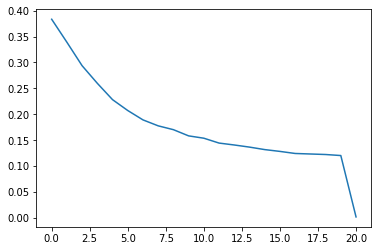

In [30]:
import matplotlib.pyplot as plt
plt.plot(loss1)

In [50]:
xv = torch.transpose(xv, 0, 1)
yv = torch.transpose(yv, 0, 1)
n_epoch=20

net.load_state_dict(torch.load('checkpoint.pth'))

steps = xv.shape[1] // batch_size

for step in range(steps):

    valid_error = 0.

    X = xv[:, step * batch_size : (step + 1) * batch_size, :]
    y = yv[:, step * batch_size : (step + 1) * batch_size]
    y = y.reshape(-1).long()
    
    y_pred = net(X)
       
    #y_pred = y_pred.repeat(1, 1, 2)
    #y_pred[:, :, 1] = 1 - y_pred[:, :, 0]
    y_pred = y_pred.view(-1, 2)
    
    valid_loss = criterion(y_pred, y)
    #optimizer.zero_grad()
    #train_loss.backward()
    #optimizer.step()
    
    valid_error+=valid_loss.item()
valid_error=valid_error/steps

        
print("Step: {}, Training Error, {}".format(step, valid_error))    
    


Step: 10, Training Error, 0.6302814917130903
